In [1]:
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
from IPython.display import clear_output
# from deadlineSchedulingEnv import deadlineSchedulingEnv
import concurrent.futures
import numpy as np

In [2]:
GAMMA = 0.99
LEARNING_RATE = 1e-5

MEMORY_SIZE = 1000
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.999

In [3]:
state_dim=1
action_dim=2
intermediate_dim=16

In [4]:
action_space=[0,1]
state_space=[i for i in range(1000)]

N=2
M=1
epsilon=1.0
subsidy=0.00
arm_indexes=[i for i in range(N)]
p=0.25
q=0.75
all_states=[]

In [5]:
# def cost_rate(state1,state2,b1=5,b2=1,c1=0.1,c2=0.1):
#     return b1*state1+b2*state2+c1*state1**2+c2*state2**2

In [6]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,state_dim)))
        model.add(Dense(512,activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        # model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        model.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=self.lr), loss = "mse", metrics = ['accuracy'])
        return model

In [7]:
class DQNSolver:
    def __init__(self, all_states,state_space,action_space, decay_coe = 0.99, 
                  memory_size = MEMORY_SIZE,EXPLORATION_DECAY=EXPLORATION_DECAY,LEARNING_RATE=LEARNING_RATE,EPSILON_MAX=EPSILON_MAX,EPSILON_MIN=EPSILON_MIN,BATCH_SIZE=BATCH_SIZE):
    
        self.all_states=all_states
        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        self.exploration_decay=EXPLORATION_DECAY
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel((1,self.states), self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        # if self.epsilon>self.min_eps:
        self.epsilon*=self.exploration_decay
        if self.epsilon<0.01:
            self.epsilon=0.01
        # else:
        #     self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done,subsidy):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done,subsidy])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
    

        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_dim)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_dim)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print(future_qvalue)

            for index, (state, action, reward, state_, done,subsidy) in enumerate(SARS):
                if done == True:
                    Qtarget = reward +(1-action)*(subsidy)
                else:
                    Qtarget = reward +(1-action)*(subsidy) + np.max(future_qvalue[index][0])-np.array(self.model.Qpolicy.predict_on_batch((self.state_shape(self.all_states)).reshape(len(self.all_states),1,state_dim))).sum()/(len(self.all_states)*action_dim)
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
            loss = self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            


                
  

In [8]:
def cost_rate(state1,b1=0.01,c1=0.0):
    return b1*state1+c1*state1**2


In [9]:
# def step(state1,state2,a1,a2,all_states1,all_states2):
#     if a1==0 and a2==0:
#         probs=[5/21.0,1/21.0,15/21.0]
#         new_state1,new_state2=np.random.choice([[state1,state2+1],[state1+1,state2],[state1,state2]],replace=True,p=probs)
#     elif a1==1 and a2==0:
#         probs=[5/21.0,1/21.0,3/21.0,12/21.0]
#         new_state1,new_state2=np.random.choice([[state1,state2+1],[state1+1,state2],[state1-1,state2],[state1,state2]],replace=True,p=probs)
#     elif a1==0 and a2==1:
#         probs=[5/21.0,1/21.0,12/21.0,3/21.0]
#         new_state1,new_state2=np.random.choice([[state1,state2+1],[state1+1,state2],[state1,state2-1],[state1,state2]],replace=True,p=probs)
#     else:
#         probs=[5/21.0,1/21.0,3/21.0,12/21.0]
#         new_state1,new_state2=np.random.choice([[state1,state2+1],[state1+1,state2],[state1-1,state2],[state1,state2-1]],replace=True,p=probs)
    
#     if new_state1>all_states1[len(all_states1)-1]:
#         all_states1.append(new_state1)
#     if new_state2>all_states2[len(all_states2)-1]:
#         all_states2.append(new_state2)

#     time=np.random.exponential(21)
#     reward=-cost_rate(state1,state2)*time
#     return[new_state1,new_state2,reward]


In [10]:
def step(state,action,all_states):
    
    if action==1:
        probs=[q*(1-p),(1-p)*(1-q)+p*q,p*(1-q)]
        new_state=np.random.choice([state-1,state,state+1],replace=True,p=probs)
    else:
        probs=[p,1-p]
        new_state=np.random.choice([state,state+1],replace=True,p=probs)
    time=np.random.exponential(4)
    reward=-cost_rate(state)*time
    if len(all_states)==0:
        all_states.append(new_state)
    else:
        if new_state>all_states[-1]:
            all_states.append(new_state)
    if new_state<0:
        new_state=0
    if new_state>20:
        new_state=20
    return[new_state,reward]

In [11]:
# Q=np.zeros((len(state_space),len(action_space)))

In [12]:


# def act(Q_values,epsilon,state):
#   if np.random.random()<epsilon:
#     action=random.choice([0,1])
#   else:
#     action=np.argmax(Q_values[state])
#   return action

In [13]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
nu=np.zeros((len(state_space),len(action_space)))
nu.shape

(1000, 2)

In [14]:
dqn_solver=DQNSolver(all_states=state_space,state_space=state_dim,action_space=action_dim)


2024-06-25 17:48:49.953037: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-25 17:48:49.953058: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-25 17:48:49.953065: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-25 17:48:49.953094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-25 17:48:49.953107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1

In [16]:
def alpha(i):
    return 1/(1+(i/10000))
    # return 0.02

In [17]:
epsilons=[]
threshold=0.1
subsidy=0
subsidy_last=0
subsidy_curr=0
all_states=[]

In [18]:
# for i in range(Q.shape[0]):
#     Q[i][1]=0.00001


In [19]:
for i in range(1,25000):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  # alpha=1/np.ceil(1+i/1000)
  # if(i<50000):
  #   beta=0
  # else:
  print(i)

  if i%50==0:
    beta=1/(1+np.ceil((i)*np.log(i)/1000))
    kappa=1/(1+np.ceil((i**2)/1000))
  else:
    beta=0
    kappa=0
  # beta=0.005
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      s=np.reshape(current_state[index],(1,state_dim))
      if current_state[index]==0:
        action=0
      else: 
        action=dqn_solver.act(s)
      # if i%5000==0:
      #   action=act(Q,1,current_state[index])
      # else:
      #   action=act(Q,epsilon,current_state[index])
      action_sum+=action
      x=step(current_state[index],action,all_states)
      # x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      s_=np.reshape(new_state,(1,state_dim))
      reward=x[1]
      dqn_solver.remember(s, action, reward, s_, False,subsidy)
      dqn_solver.train()
      current_state[index]=new_state
      reward_sum+=reward
      #print(x)
  # print(i)
  # if i>2000:
  #   print(Q[20:30])
  dqn_solver.update_target_model()
  dqn_solver.decrement_epsilon()
  subsidy+=beta*(action_sum-M)/N
  # subsidy=subsidy_curr+beta*(action_sum-M)/N+kappa*(subsidy_curr-subsidy_last)
  # if i>0:
  #   subsidy_last=subsidy_curr
  # subsidy_curr=subsidy
  subsidies.append(subsidy)
  # epsilon=epsilon*gamma

  # if epsilon<threshold:
  #   epsilon=threshold
  # if i%500000==0:
  #   threshold=threshold/10
  # epsilon=epsilon*0.999
  # if epsilon<=0.001:
  #   epsilon=0.001
  clear_output(wait=True)
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  epsilons.append(epsilon)








24999


In [20]:
current_state

[20, 20]

In [21]:
nu

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

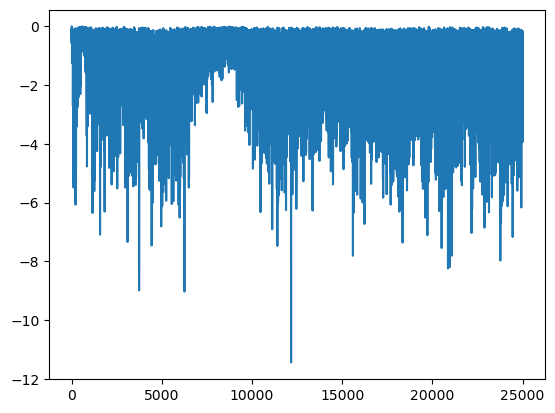

In [22]:
plt.plot(rewards)

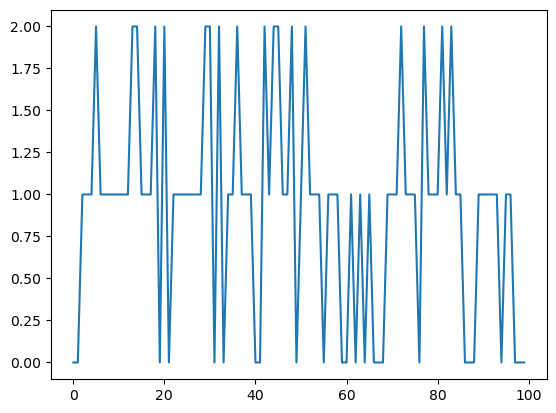

In [23]:
plt.plot(action_sums[:100])

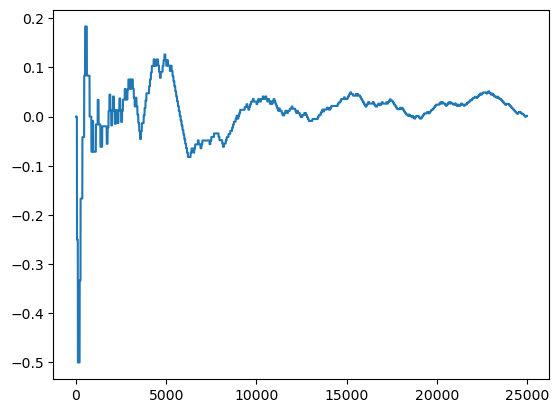

In [24]:
plt.plot(subsidies)